In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Задание №1
Написать функцию для подсчёта метрики `Retention` по дням с момента регистрации пользователей.

In [3]:
reg_time = pd.read_csv('~/shared/problem1-reg_data.csv', sep = ';')
reg_time['reg_ts'] = pd.to_datetime(reg_time['reg_ts'], unit = 's')
reg_time['start_date'] = reg_time['reg_ts'].dt.date

In [4]:
enter_time= pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')
enter_time['auth_ts'] = pd.to_datetime(enter_time['auth_ts'], unit = 's')
enter_time['activity_date'] = enter_time['auth_ts'].dt.date

In [5]:
print(reg_time.isna().sum())
print(enter_time.isna().sum())

reg_ts        0
uid           0
start_date    0
dtype: int64
auth_ts          0
uid              0
activity_date    0
dtype: int64


В исходных данных **отсутствуют пропуски**.

In [6]:
reg_time_duplicates = reg_time[reg_time.duplicated()]
print(reg_time_duplicates)

enter_time_duplicates = enter_time[enter_time.duplicated()]
print(enter_time_duplicates)

Empty DataFrame
Columns: [reg_ts, uid, start_date]
Index: []
Empty DataFrame
Columns: [auth_ts, uid, activity_date]
Index: []


В исходных данных **отсутствуют дублирующиеся строки**.

In [5]:
print(f'test_reg_time shape:{reg_time.shape}')
print(f'test_enter_time shape:{enter_time.shape}')


test_reg_time shape:(1000000, 3)
test_enter_time shape:(9601013, 3)


In [26]:
print(f'Unique users in reg_time:{reg_time.uid.nunique()}')
print(f'Unique users in enter_time:{enter_time.uid.nunique()}')

Unique users in reg_time:2874
Unique users in enter_time:2874


In [11]:
def count_ret_rate(reg_time, enter_time, start_date, end_date):
    reg_time['reg_ts'] = pd.to_datetime(reg_time['reg_ts'], unit = 's')
    reg_time['start_date'] = reg_time['reg_ts'].dt.date
    
    enter_time['auth_ts'] = pd.to_datetime(enter_time['auth_ts'], unit = 's')
    enter_time['activity_date'] = enter_time['auth_ts'].dt.date
    
    start_and_activ = pd.merge(reg_time, enter_time, on = 'uid', how='inner')
    #подсчёт числа дней, прошедших с момента регистрации в приложении до целевого действия
    #результат запишем в колонку 'days_since_start'
    start_and_activ['days_since_start'] = (start_and_activ['auth_ts'] - start_and_activ['reg_ts'])\
    .astype('timedelta64[D]').astype('int')
    
    #переводим строки дат в тип данных 'datetime' для выполнения среза
    start = pd.to_datetime(start_date).date()
    end = pd.to_datetime(end_date).date()

    #выполним когортный анализ, где в качестве когорт будем использовать даты регистрации
    #для каждой даты отобразим количество уникальных посетителей в таблице cohort_table,
    #а также посчитаем метрику retention за 25 дней
    cohort_table = start_and_activ.groupby(['days_since_start', 'start_date'], as_index = False) \
    .agg({'uid':'nunique'}) \
    .pivot(index='start_date', columns='days_since_start', values='uid')[start : end]



    base_month = cohort_table[0]    
    retention_cohort =  cohort_table.divide(base_month, axis = 0).round(3)
    
    plt.figure(figsize=(18,14))
    plt.title('Retention Table')
    ax = sns.heatmap(data=retention_cohort.iloc[:,:25], annot = True, fmt='.0%', vmin = 0.0, vmax = 1,cmap='Reds')
    ax.set_yticklabels(retention_cohort.index)
    fig = ax.get_figure()
    
    return cohort_table.iloc[:, :25] 

days_since_start,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
start_date,,,,,,,,,,,,,,,,,,,,,
2020-09-01,1586.0,54.0,79.0,77.0,82.0,83.0,125.0,64.0,78.0,75.0,...,70.0,80.0,68.0,75.0,50.0,64.0,54.0,8.0,NaN,NaN
2020-09-02,1588.0,72.0,64.0,87.0,97.0,103.0,120.0,75.0,66.0,78.0,...,65.0,86.0,60.0,62.0,72.0,60.0,13.0,NaN,NaN,NaN
2020-09-03,1591.0,76.0,88.0,89.0,95.0,128.0,136.0,77.0,101.0,97.0,...,85.0,71.0,79.0,83.0,66.0,11.0,NaN,NaN,NaN,NaN
2020-09-04,1593.0,61.0,65.0,66.0,79.0,118.0,121.0,62.0,71.0,77.0,...,68.0,77.0,70.0,65.0,13.0,NaN,NaN,NaN,NaN,NaN
2020-09-05,1596.0,78.0,64.0,81.0,85.0,118.0,109.0,65.0,85.0,90.0,...,73.0,83.0,58.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-06,1599.0,79.0,77.0,88.0,90.0,97.0,125.0,81.0,101.0,77.0,...,74.0,61.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-07,1601.0,83.0,70.0,80.0,101.0,109.0,105.0,64.0,80.0,97.0,...,79.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-08,1604.0,63.0,58.0,74.0,92.0,124.0,139.0,72.0,84.0,88.0,...,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-09,1607.0,47.0,66.0,84.0,106.0,95.0,107.0,75.0,67.0,77.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


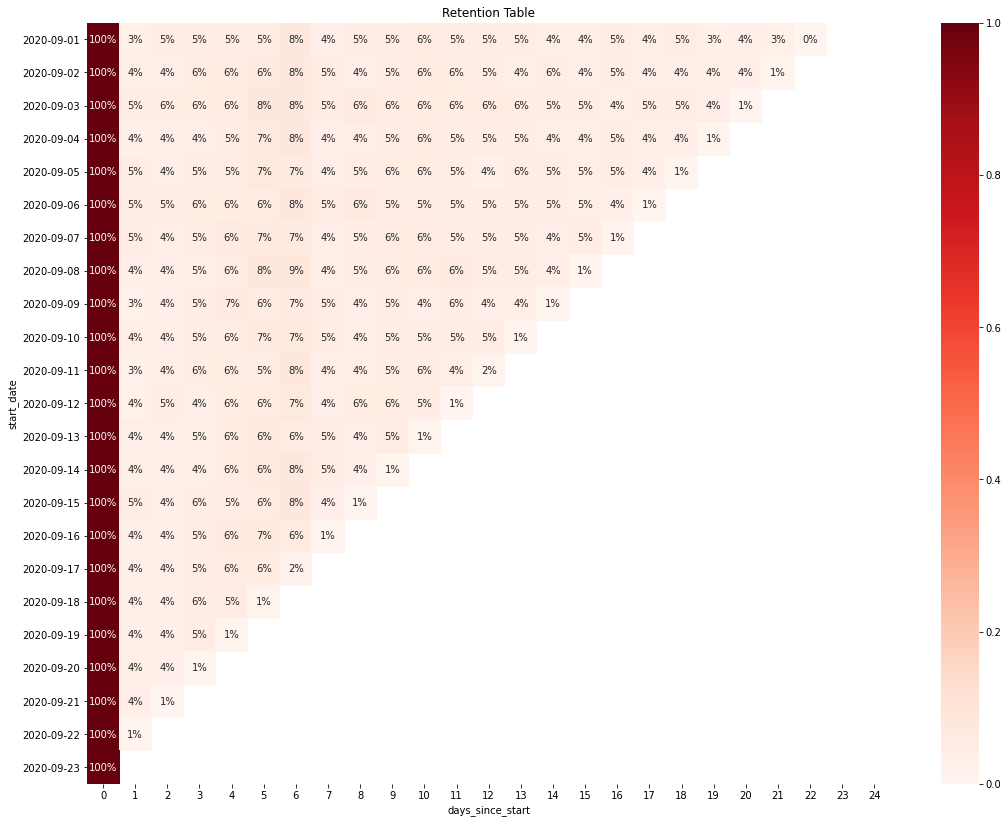

In [12]:
count_ret_rate(reg_time, enter_time, '2020-09-01','2020-09-23')

## Задание №2 
Проведение A/B теста для проверки гипотезы о выгодности внедрения акционных предложений для геймеров.

In [3]:
stocks_for_gamers = pd.read_csv('Проект_1_Задание_2.csv', sep = ';')
stocks_for_gamers.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [4]:
stocks_for_gamers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [5]:
stocks_for_gamers.shape

(404770, 3)

In [6]:
stocks_for_gamers.testgroup.value_counts()

b    202667
a    202103
Name: testgroup, dtype: int64

Отсюда делаем вывод, что группа `a` соответствует **контрольной группе**, а группа `b` соответствует **тестовой группе**.

In [7]:
stocks_for_gamers.groupby('testgroup').agg({'revenue':'mean'}).reset_index()

,testgroup,revenue
0,a,25.413720
1,b,26.751287


In [4]:
control_group = stocks_for_gamers[stocks_for_gamers['testgroup'] == 'a']
test_group = stocks_for_gamers[stocks_for_gamers['testgroup'] == 'b']

In [9]:
control_group.revenue.describe()

count    202103.000000
mean         25.413720
std         920.768137
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

In [10]:
test_group.revenue.describe()

count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64

###  ARPU

Сравним, насколько стат. значимо отличается показатель  `ARPU` для двух групп:

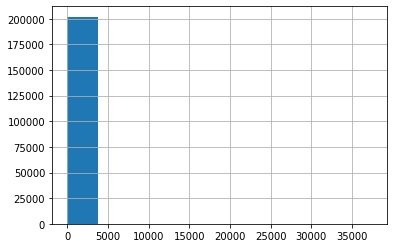

In [5]:
control_group.revenue.hist()

Большая часть **ARPU** приходится на промежуток $[0;5000]$. При этом в данных также присутствуют пользователи, приносящие прибыль в районе **30000**, что явно превосходит максимум тестовой группы. Определим отношение числа пользователей, платящих больше **5000** к тем, кто платит меньше **5000**:

In [6]:
(control_group[control_group['revenue'] > 5000].shape[0]) / (control_group[control_group['revenue'] < 5000].shape[0])

0.0006089711852658679

Выше получили, что таких пользователей составляют меньше тысячной от числа тех, кто платит $[0;5000]$. Поэтому в конце рассмотрим случаи, когда из контрольной выборки такие пользователи удаляются(т.е. считаются выбросом), и когда их учитываем.

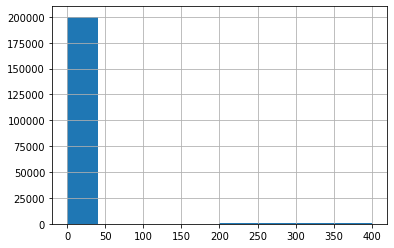

In [7]:
control_group[control_group['revenue'] < 5000].revenue.hist()

В контрольной группе стали немного видны пользователи с $Revenue = [200;400]$

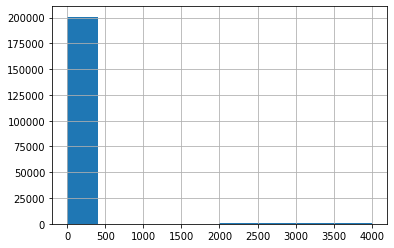

In [20]:
test_group.revenue.hist()

По распределению `Revenue` видно, что распределения сильно отличается от нормального. Применим непараметрический 
критерий Мана-Уитни для оценки стат.значимости отличия `APRU` для двух групп в случае учёта выбросов и без учёта выбросов:

**H0** - в генеральной совокупности никакого различия между ARPU нет

**H1** - в генеральной совокупности ARPU двух групп отличаются стат. значимо

In [38]:
print(stats.mannwhitneyu(control_group[control_group['revenue'] < 30000].revenue, test_group.revenue ))

MannwhitneyuResult(statistic=20466331335.0, pvalue=0.8675688044687636)


In [39]:
print(stats.mannwhitneyu(control_group.revenue, test_group.revenue ))

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)


Получили, что в обоих случаях  $p-value > 0.05$, поэтому нет оснований отвергать нулевую гипотезу. Считаем, что 
в ARPU у тестовой выборки отличается не стат. значимо. Заметим также, что удаление выбросов может сильно повлиять 
на итоговый результат.

### ARPPU

Теперь оценим показатель среднюю прибыль только от платящих польователей. Попробуем также применить
трансформацию к данным в виде логарифма. Учтём также наличие больших выбросов в контрольной выборке:

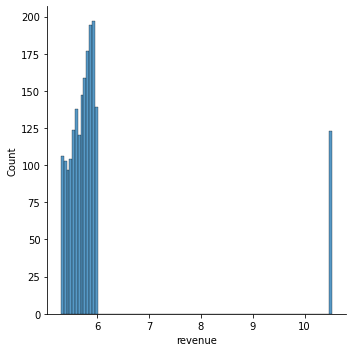

In [5]:
#контрольная выборка с выбросами
sns.displot(np.log(control_group[control_group['revenue'] > 0].revenue), kde = False)

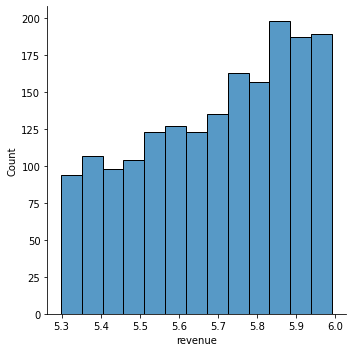

In [6]:
#контрольаная выборка без выбросов
sns.displot(np.log(control_group[(control_group['revenue'] > 0) & (control_group['revenue'] <30000)].revenue), kde=False)

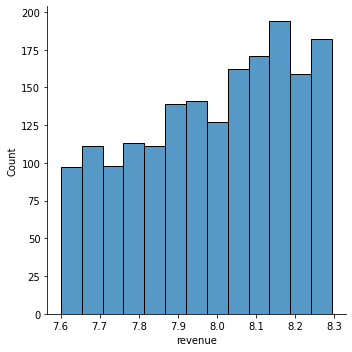

In [7]:
#тестовая выборка
sns.displot(np.log(test_group[test_group['revenue'] > 0].revenue), kde=False)

In [13]:
control_revenue = control_group[control_group['revenue'] > 0].revenue
control_no_outliers = control_group[(control_group['revenue'] > 0) & (control_group['revenue'] < 30000)].revenue
test_revenue = test_group[test_group['revenue'] > 0].revenue

logged_control_revenue = np.log(control_revenue)
logged_control_no_outliers = np.log(control_no_outliers)
logged_test_revenue = np.log(test_revenue)

print(stats.normaltest(logged_control_revenue))
print(stats.normaltest(logged_control_no_outliers))                               
print(stats.normaltest(logged_test_revenue))


NormaltestResult(statistic=1340.7214063175247, pvalue=7.3459122018786625e-292)
NormaltestResult(statistic=636.0059495324283, pvalue=7.817408923593704e-139)
NormaltestResult(statistic=594.7849234183507, pvalue=6.983850275213673e-130)


Несмотря на попытку трансформации данных с помощью логарифмирования распределение переменной **revenue** не стало нормальным. Будем  работать с исходными данными(до применения логарифма).Для оценки стат.значимости отличия **ARPPU** у двух выборок воспользуемся непараметрическим критерием Мана-Уитни:

In [14]:
print(f'Cреднее значение для контрольной выборки: {control_revenue.mean()}')
print(f'Cреднее значение для контрольной выборки без выбросов: {control_no_outliers.mean()}')
print(f'Cреднее значение для тестовой выборки: {test_revenue.mean()}')

Cреднее значение для контрольной выборки: 2663.9984439834025
Cреднее значение для контрольной выборки без выбросов: 302.45817174515236
Cреднее значение для тестовой выборки: 3003.6581717451522


In [15]:
#тест Мана-Уитни для контрольной выборки с выбросами:
print(stats.mannwhitneyu(control_revenue,test_revenue))

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)


In [16]:
#тест Мана-Уитни для контрольной выборки без выбросов:
print(stats.mannwhitneyu(control_no_outliers,test_revenue))

MannwhitneyuResult(statistic=0.0, pvalue=0.0)


Посмотрим на статистику платящих и неплатящих клиентов:

In [33]:
print('Количество платящих пользователей в контрольной группе:', 
      control_group[control_group['revenue'] > 0].user_id.nunique() )

print('Количество пользователей в контрольной группе, заплативших меньше 30000 :',
        control_group[(control_group['revenue'] > 0) & (control_group['revenue'] < 30000)].user_id.nunique())
print('Количество неплатящих пользователей в контрольной группе',
     control_group[control_group['revenue'] == 0].user_id.nunique())
print('\n')
print('Количество платящих пользователей в тестовой группе:', 
     test_group[test_group['revenue'] > 0].user_id.nunique())
print('Количество неплатящих пользователей в тестовой группе:', 
     test_group[test_group['revenue'] == 0].user_id.nunique())

Количество платящих пользователей в контрольной группе: 1928
Количество пользователей в контрольной группе, заплативших меньше 30000 : 1805
Количество неплатящих пользователей в контрольной группе 200175


Количество платящих пользователей в тестовой группе: 1805
Количество неплатящих пользователей в тестовой группе: 200862


Получили, что в обоих случаях $p-value < 0.05$, то есть  `ARPPU` **у тестовой группы стат. значимо выше**, чем `ARPPU`у контрольной группы.

### Вывод: 

Для оценки результатов A/B тестирование будем использовать метрики `ARPU`(average revenue per user) и `ARPPU`(average revenue per paying user). Первая метрика показывает среднюю выручку со всех активных пользователей продукта за текущий период(платящих и неплатящих). Вторая метрика показывает среднюю выручку только с платящих пользователей.

В результате эксперимента было получено, что $ARPU_{test} > ARPU_{control}$, но эта разница не стат. значима. В то же время $ARPPU_{test} > ARPPU_{control}$, и эта разница стат. значима. 

При меньшем или равном количестве платящих пользователей в тестовой группе мы получили стат. значимое отличие `ARPPU`. Следовательно можно предположить, что акцонные предложения не повлияли на увеличение выручки со всех пользоват, но платящие пользователи готовы были покупать больше, чем обычно. Следовательно, можно посоветовать компании поработать над увеличением конверсии пользователя продукта в клиента.

## Задание 3

Рассмотрим отдельно случаи обычной игровой механики и усложнённой.

Обычная игровая механика:

1) **`Фактор-виральности`**


$K-фактор = X*Y*Z$,

где  *X* — процент пользователей, которые пригласили новых пользователей, *Y* — среднее число людей, которых пригласил единичный пользователь, *Z* — число пользователей, принявших приглашение. Вполне вероятно, что игроки, знающие и участвующие в прохождении тематического события могут рассказать о нём тем пользователям, которые ещё о нем не слышали или немного утратили интерес к игре. Хорошее тематическое событие с перспективой получить бонусы может вернуть интерес к игре.

2) **`Средняя продолжительность сесссии(average session lenght, ASL)`**

$ASL = \frac{T}{N}$

T - суммарная продолжительность сессий за период, N - общее количество сессий за период

3) **`Количество сессий на пользователя`** - поможет понять, как часто один пользователь возвращается в игру. Сравнить этот показатель в обычный и "тематический" день.

4) **`DAU`** (daily average users) - сколько пользователей в день заходят в приложение. Для оценки успешности введения тематических событий необходимо сравнить данный параметр с `DAU` обычного дня.

5) **`Глубина прохождения`** - звучит немного странно, но здесь имеется в виду, сколько уровней готов пройти пользователь игры за один визит. Поможет оценить энтузиазм пользователей в получении бонусов и уникальных предметов. 


Усложнённая игровая механика:
Учитывая, что механика усложнилась и есть риск возвращения на старые уровни, то можно ожидать, что это негативно
скажется на вышеописанных метриках. Следовательно дополнительно можно ввести следующие метрики:

1) **`Средняя продолжительность игры после неудачной попытки`** - позволит оценить влияние потери уровня на желание пользователя продолжать игру.

2) **`Доля пользователей, которые вышли после неудачной попытки`** - неудачная попытка и потеря уровня -  это негативные события. Многим не нравится проигрывать, а потеря уровня усиливает негативное впечатления пользователя.Сравнение значений у обычной и сложной механик позволит оценить, насколько сильное влияние оказывает потеря уровня.